In [ ]:
# For using the fourht model
! pip install einops

# Colab initialization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
! cd "gdrive/My Drive/ml4cv"

In [ ]:
! git clone "https://github.com/EnricoPittini/ml4cv-project"

In [ ]:
%cd -0
%cd "ml4cv-project"

# Initialization

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import Compose, ToTensor, RandomResizedCrop, RandomAffine, ColorJitter, RandomHorizontalFlip
from torchvision.datasets import CIFAR10, MNIST, Flowers102, ImageFolder
from torch.utils.data import DataLoader

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cpu


In [18]:
# For reproducibility

import random 
import torch

random_seed = 44

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Create Dataset

In [19]:
from utils.diffusionDataset import DiffusionDataset, TimestepPredictionDataset

image_size = (128, 128)
batch_size = 32 #16
batch_size_eval = 2*batch_size
#variance_schedule = np.ones(20)*0.0011
#variance_schedule = np.linspace(0, 2e-2, 1000)       # from Ho et al. (2020)
#alpha_t = np.cos((t/T+s)/(1+s)*np.pi/2)**2             # from Nichol & Dhariwal (2021)
variance_schedule = np.linspace(0, 5e-3, 1000)

Training set

In [20]:
# We use the test set as training set, and the training set as test set.
# This because the actual test set has more samples than the training one.

dataset_train = Flowers102(root='datasets', split='test',
                  download=True)

print(f'Number of training samples: {len(dataset_train)}')

dataset_train_diff = DiffusionDataset(data=dataset_train,
                           variance_schedule=variance_schedule,
                           transform=Compose([ToTensor(),
                                            RandomResizedCrop(image_size),
                                            ColorJitter(brightness=.2, hue=.2),
                                            RandomHorizontalFlip(),
                                            RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.8, 1.2))]),
                           random_seed=random_seed)

dataset_train_timestepPred = TimestepPredictionDataset(diffusion_dataset=dataset_train_diff)

dataloader_train = DataLoader(dataset_train_timestepPred,
                         batch_size=batch_size,
                         pin_memory=True,
                         shuffle=True)

Number of training samples: 6149


Validation set

In [21]:
dataset_val = Flowers102(root='datasets', split='val',
                  download=True)

print(f'Number of validation samples: {len(dataset_val)}')

dataset_val_diff = DiffusionDataset(data=dataset_val,
                           variance_schedule=variance_schedule,
                           transform=Compose([ToTensor(),
                                            RandomResizedCrop(image_size)]),
                           validation=True,
                           random_seed=random_seed)

dataset_val_timestepPred = TimestepPredictionDataset(diffusion_dataset=dataset_val_diff)

dataloader_val = DataLoader(dataset_val_timestepPred,
                         batch_size=batch_size_eval)

Number of validation samples: 1020


Test set

In [22]:
dataset_test = Flowers102(root='datasets', split='train',
                  download=True)

print(f'Number of test samples: {len(dataset_test)}')

dataset_test_diff = DiffusionDataset(data=dataset_test,
                           variance_schedule=variance_schedule,
                           transform=Compose([ToTensor(),
                                            RandomResizedCrop(image_size)]),
                           validation=True,
                           random_seed=random_seed)

dataset_test_timestepPred = TimestepPredictionDataset(diffusion_dataset=dataset_test_diff)

dataloader_test = DataLoader(dataset_test_timestepPred,
                         batch_size=batch_size)

Number of test samples: 1020


## Have a look at some elements in the dataset

Forward diffusion step at stage t = 667.


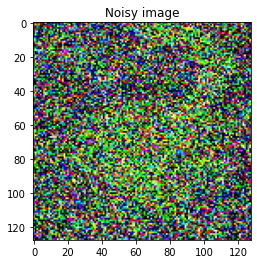

In [9]:
from utils.reconstruction import reconstruct_image_from_noise

im_n, t = next(iter(dataloader_train))
im_n = im_n[0]
t = t.numpy()[0]

print(f"Forward diffusion step at stage t = {t}.")

plt.imshow(im_n.permute(1, 2, 0).clip(0, 1))
plt.title('Noisy image')
plt.show()

## Plot the variance schedule and $\bar{\alpha}$

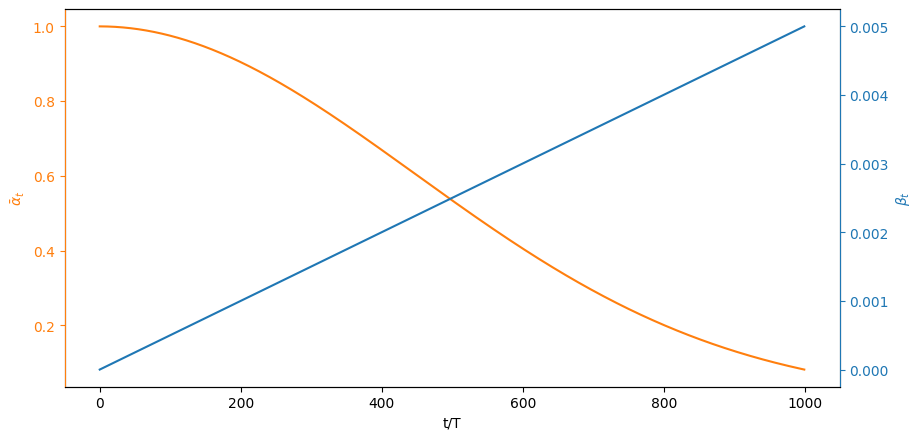

In [10]:
from utils.diffusionDataset import get_alpha_bar

T = 1000
t = np.arange(T+1)
s = 1e-3

alpha_bar = get_alpha_bar(variance_schedule)

w, h, dpi = 1000, 500, 100
fig, ax1 = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)
ax2 = ax1.twinx()

ax1.set_xlabel('t/T')

color = 'C1'
ax1.plot(alpha_bar, color=color)
ax1.set_ylabel(r'$\bar{\alpha}_t$', color=color)
ax2.spines['left'].set_color(color)
ax1.tick_params(axis='y', colors=color)

color = 'C0'
ax2.plot(variance_schedule, color=color)
ax2.set_ylabel(r'$\beta_t$', color=color)
ax2.spines['right'].set_color(color)
ax2.tick_params(axis='y', colors=color)

plt.show()

# Train Model

In [15]:
from models_timestep_prediction.model import Model
from utils.training_timestep_prediction import train_model

from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import AdamW
from functools import partial

net = Model(img_shape=(3,)+image_size, device=device)

epochs = 50
additional_info = {'batch_size': batch_size,
                   'image_size': image_size,
                   'variance_schedule': variance_schedule
                  }

checkpoint_dict = train_model(net=net,
                              dataloader_train=dataloader_train,
                              dataloader_val=dataloader_val,
                              loss_function=torch.nn.MSELoss(),
                              epochs=epochs,
                              optimizer=partial(AdamW, lr=0.1),
                              scheduler=partial(OneCycleLR, max_lr=0.005, epochs=epochs, steps_per_epoch=len(dataloader_train),
                                                pct_start=0.1),
                              device=device,
                              checkpoint_folder='checkpoints/' + f'{type(net)}'.split('.')[-1][:-2],
                              clear_previous_checkpoints=True,
                              additional_info=additional_info)

plt.plot(checkpoint_dict['loss_history'], 'o-', label='train')
plt.plot(checkpoint_dict['loss_history_val'], 'o-', label='val')
plt.yscale('log')
plt.grid()
plt.title('Log Loss curve')
plt.legend()

plt.show()

Device: cpu
No checkpoint found in checkpoints/Model, using default initialization.
 
Epoch: 1/50
torch.Size([32, 128])
tensor(390449., grad_fn=<MseLossBackward0>)
tensor(390449., grad_fn=<MseLossBackward0>)
tensor(390449., grad_fn=<MseLossBackward0>)
torch.Size([32, 128])s/step, lr: 0.0002, loss: 3.9e+05                                 
tensor(245961.3125, grad_fn=<MseLossBackward0>)
tensor(245961.3125, grad_fn=<MseLossBackward0>)
tensor(245961.3125, grad_fn=<MseLossBackward0>)
torch.Size([32, 128])s/step, lr: 0.0002, loss: 3.18e+05                                
tensor(272472.7500, grad_fn=<MseLossBackward0>)
tensor(272472.7500, grad_fn=<MseLossBackward0>)
tensor(272472.7500, grad_fn=<MseLossBackward0>)
torch.Size([32, 128])s/step, lr: 0.0002, loss: 3.03e+05                                
tensor(269741.6562, grad_fn=<MseLossBackward0>)
tensor(269741.6562, grad_fn=<MseLossBackward0>)
tensor(269741.6562, grad_fn=<MseLossBackward0>)
torch.Size([32, 128])s/step, lr: 0.0002, loss: 2.95e

KeyboardInterrupt: 

In [ ]:
from utils.training import load_checkpoint_dict

checkpoint_dict = load_checkpoint_dict(checkpoint_folder='checkpoints/' + f'{type(net)}'.split('.')[-1][:-2])
plt.plot(checkpoint_dict['loss_history'], 'o-', label='train')
plt.plot(checkpoint_dict['loss_history_val'], 'o-', label='val')
plt.yscale('log')
plt.grid()
plt.title('Log Loss curve')
plt.legend()

plt.show()

# Test Performance

## Loading the best model

In [ ]:
from models.secondModel import BottleneckResidual
from models.fourthModel import FourthModel
from utils.eval import reconstruct_and_compare
from utils.storage import load_weights

# net = BottleneckResidual(img_shape=(3,)+image_size, device=device)
net = FourthModel(dim=image_size[0], device=device, use_convnext=False, dim_mults=(1,2,4))
net_name = f'{type(net)}'.split('.')[-1][:-2]

files=os.listdir(f'checkpoints/{net_name}')
load_weights(net, f"checkpoints/{net_name}/{[f for f in files if 'best' in f][0]}")
net.to(device)

## Test score on the flowers test dataset

In [ ]:
from utils.training import validate
test_score = validate(net=net,
          dataloader_val=dataloader_test,
          loss_function=torch.nn.MSELoss(),
          device=device,
          prefix='Test ')

## Qualitative analysis on a flower test image

Get an image from the dataset

In [ ]:
from utils.reconstruction import reconstruct_image_from_noise
from utils.eval import reconstruct_and_compare

(noisy_image_batch, t_batch), noise_batch = next(iter(dataloader_test))
i = np.argmin(t_batch.numpy())

noisy_image = noisy_image_batch.numpy()[i]
t = t_batch.numpy()[i]
noise = noise_batch.numpy()[i]

# true original image
original_image = reconstruct_image_from_noise(noisy_image=noisy_image,
                                              noise=noise,
                                              t=t,
                                              variance_schedule=variance_schedule)

orig_name = "flower"

print(f't = {t}')

In [ ]:
output_folder = f'result_pictures/{net_name}_{orig_name}_{t}'
step = [1, 5]
rec_images = reconstruct_and_compare(net, original_image, noisy_image, t, variance_schedule, device, output_folder=None, step_size=step, use_plotly=True)

## Qualitative analysis on benchmark images

Ship image

In [ ]:
from matplotlib import image
from utils.diffusionDataset import get_alpha_bar

original_image = np.asarray(image.imread('test_pictures/ship.jpg'), dtype=np.float32)/255
orig_name = "ship"

original_image = original_image.transpose(2, 0, 1)

image_size_test = original_image.shape[1:]

t = 50

a = get_alpha_bar(variance_schedule)[t]
noisy_image = np.sqrt(a)*original_image + np.sqrt(1-a)*np.random.normal(size=original_image.shape)
noisy_image = noisy_image.clip(0, 1)

In [ ]:
output_folder = f'result_pictures/{net_name}_{orig_name}_{t}'
step = [1, 5]
rec_images = reconstruct_and_compare(net, original_image, noisy_image, t, variance_schedule, device, output_folder=output_folder, step_size=step, use_plotly=True)

Flower 1 image

In [ ]:
from matplotlib import image
from utils.diffusionDataset import get_alpha_bar

original_image = np.asarray(image.imread('test_pictures/flower_1.jpg'), dtype=np.float32)/255
orig_name = "flower_1"

original_image = original_image.transpose(2, 0, 1)

image_size_test = original_image.shape[1:]

t = 50

a = get_alpha_bar(variance_schedule)[t]
noisy_image = np.sqrt(a)*original_image + np.sqrt(1-a)*np.random.normal(size=original_image.shape)
noisy_image = noisy_image.clip(0, 1)

In [ ]:
output_folder = f'result_pictures/{net_name}_{orig_name}_{t}'
step = [1, 5]
rec_images = reconstruct_and_compare(net, original_image, noisy_image, t, variance_schedule, device, output_folder=output_folder, step_size=step, use_plotly=True)

Flower 2 image

In [ ]:
from matplotlib import image
from utils.diffusionDataset import get_alpha_bar

original_image = np.asarray(image.imread('test_pictures/flower_2.jpg'), dtype=np.float32)/255
orig_name = "flower_2"

original_image = original_image.transpose(2, 0, 1)

image_size_test = original_image.shape[1:]

t = 50

a = get_alpha_bar(variance_schedule)[t]
noisy_image = np.sqrt(a)*original_image + np.sqrt(1-a)*np.random.normal(size=original_image.shape)
noisy_image = noisy_image.clip(0, 1)

In [ ]:
output_folder = f'result_pictures/{net_name}_{orig_name}_{t}'
step = [1, 5]
rec_images = reconstruct_and_compare(net, original_image, noisy_image, t, variance_schedule, device, output_folder=output_folder, step_size=step, use_plotly=True)

## Test score on the Tiny ImageNet test dataset

In [ ]:
from utils.imagenet import load_imagenet

image_size_imagenet = 64
dataset_imagenet_val = load_imagenet(root='imagenet', split='val')

In [ ]:
dataset_imagenet_val_diff = DiffusionDataset(data=dataset_imagenet_val,
                           variance_schedule=variance_schedule,
                           transform=Compose([ToTensor(),
                                            RandomResizedCrop(image_size)]),
                           random_seed=random_seed)

dataloader_imagenet_val = DataLoader(dataset_imagenet_val_diff,
                         batch_size=batch_size_eval)

Example of image (without noise)

In [ ]:
img, label = next(iter(dataset_imagenet_val))

plt.imshow(img)

Example of image with noise

In [ ]:
(img_noisy, t), noise = next(iter(dataset_imagenet_val_diff))
print(f't: {t}')

plt.imshow(torch.Tensor(img_noisy).permute(1, 2, 0))

Test score on ImageNet

In [ ]:
from utils.training import validate
test_score = validate(net=net,
          dataloader_val=dataloader_imagenet_val,
          loss_function=torch.nn.MSELoss(),
          device=device,
          prefix='Test ')

Visualization on an ImageNet image

In [ ]:
from utils.reconstruction import reconstruct_image_from_noise
from utils.eval import reconstruct_and_compare

(noisy_image_batch, t_batch), noise_batch = next(iter(dataloader_imagenet_val))
i = np.argmin(t_batch.numpy())

noisy_image = noisy_image_batch.numpy()[i]
t = t_batch.numpy()[i]
noise = noise_batch.numpy()[i]

# true original image
original_image = reconstruct_image_from_noise(noisy_image=noisy_image,
                                              noise=noise,
                                              t=t,
                                              variance_schedule=variance_schedule)

orig_name = "flower"

print(f't = {t}')

In [ ]:
output_folder = f'result_pictures/{net_name}_{orig_name}_{t}'
step = [1, 5]
rec_images = reconstruct_and_compare(net, original_image, noisy_image, t, variance_schedule, device, output_folder=None, step_size=step, use_plotly=True)